# Matrix Factorization

In [1]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

sns.set()

In [2]:
# Check if MPS is available
print("MPS available:", torch.backends.mps.is_available())

# Set device (remove the override)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Computation device:", device)

MPS available: True
Computation device: mps


## Loading Data

In [3]:
# loading data
df = pd.read_csv("./data/augmented_data.csv")
df.head()

,user_id,song_id,freq,artist,title,interaction
0,05b9035fe02ebdf5535ae9ec07de1e935ffa43df,SOMWTWK12AB01860CD,2.0,Vampire Weekend,White Sky,1
1,05b9035fe02ebdf5535ae9ec07de1e935ffa43df,SOBKRVG12A8C133269,1.0,Vampire Weekend,I Stand Corrected (Album),1
2,05b9035fe02ebdf5535ae9ec07de1e935ffa43df,SOXFXDH12A8C13326E,1.0,Vampire Weekend,The Kids Dont Stand A Chance (Album),1
3,05b9035fe02ebdf5535ae9ec07de1e935ffa43df,SOAYETG12A67ADA751,1.0,MIKA,Grace Kelly,1
4,05b9035fe02ebdf5535ae9ec07de1e935ffa43df,SOUFNSM12A58A77715,1.0,Vampire Weekend,Walcott (Album),1


In [4]:
# Create categorical mappings
user_to_idx = {uid: idx for idx, uid in enumerate(df["user_id"].unique())}
song_to_idx = {sid: idx for idx, sid in enumerate(df["song_id"].unique())}

# Add numerical indices to the dataframe
df["user_idx"] = df["user_id"].map(user_to_idx)
df["song_idx"] = df["song_id"].map(song_to_idx)

df

,user_id,song_id,freq,artist,title,interaction,user_idx,song_idx
0,05b9035fe02ebdf5535ae9ec07de1e935ffa43df,SOMWTWK12AB01860CD,2.0,Vampire Weekend,White Sky,1,0,0
1,05b9035fe02ebdf5535ae9ec07de1e935ffa43df,SOBKRVG12A8C133269,1.0,Vampire Weekend,I Stand Corrected (Album),1,0,1
2,05b9035fe02ebdf5535ae9ec07de1e935ffa43df,SOXFXDH12A8C13326E,1.0,Vampire Weekend,The Kids Dont Stand A Chance (Album),1,0,2
3,05b9035fe02ebdf5535ae9ec07de1e935ffa43df,SOAYETG12A67ADA751,1.0,MIKA,Grace Kelly,1,0,3
4,05b9035fe02ebdf5535ae9ec07de1e935ffa43df,SOUFNSM12A58A77715,1.0,Vampire Weekend,Walcott (Album),1,0,4
...,...,...,...,...,...,...,...,...
604651,07f2f354a2a4390624e0d04e4a555ef67e98f673,SOXELPB12A8AE46000,NaN,Faithless Featuring Dido,One Step Too Far,0,11211,157
604652,07f2f354a2a4390624e0d04e4a555ef67e98f673,SOQWYAQ12A6D4FB9A3,NaN,Rihanna,Take A Bow,0,11211,56
604653,07f2f354a2a4390624e0d04e4a555ef67e98f673,SOKTYZO12A8C13E5D9,NaN,Calle 13,Sin Coro,0,11211,1997
604654,07f2f354a2a4390624e0d04e4a555ef67e98f673,SOXEZLY12A8C137AB0,NaN,Explosions In The Sky,Your Hand In Mine,0,11211,689


## Creating Dataset and Dataloaders

In [5]:
# let's get the number of users and songs
n_users = df["user_id"].nunique()
n_songs = df["song_id"].nunique()

In [6]:
# split data into training and testing
train_df, test_df = train_test_split(df, test_size=0.2)
train_df.head()

,user_id,song_id,freq,artist,title,interaction,user_idx,song_idx
436406,607a6cf848eff1fbab6352a0c49848d303680006,SOSPXWA12AB0181875,NaN,Jack Johnson,Bubble Toes,0,7047,1125
305666,b453461f65442c831c56535a77913cb3572b2fde,SOGPBAW12A6D4F9F22,NaN,Bon Jovi,Livin' On A Prayer,0,3792,70
221166,7fe7f73cd40fca52324a41e3e4760e64bf26d531,SOSXLTC12AF72A7F54,NaN,Kings Of Leon,Revelry,0,1705,55
311488,aab67789856e4a8c9c7f85c6aa9e8a194ab4c021,SOKXYUW12A8C140229,NaN,Beyoncé feat. Slim Thug,Check On It,0,3936,844
3448,cf5cf6addec8603e360418acdc534a3e9dac30e1,SOBOUPA12A6D4F81F1,2.0,Alliance Ethnik,Sincerité Et Jalousie,1,254,341


In [7]:
class StreamingDataset(Dataset):
    def __init__(self, df, alpha=10.0):  # alpha controls the confidence scaling
        self.user_ids = df["user_idx"].values
        self.song_ids = df["song_idx"].values
        self.interactions = df["interaction"].values
        # Calculate confidence to be higher for actual interactions
        self.confidence = 1.0 + alpha * self.interactions

    def __len__(self):
        return len(self.interactions)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.user_ids[idx], dtype=torch.long),
            torch.tensor(self.song_ids[idx], dtype=torch.long),
            torch.tensor(self.interactions[idx], dtype=torch.float),
            torch.tensor(self.confidence[idx], dtype=torch.float),
        )

In [8]:
# Create datasets
train_dataset = StreamingDataset(train_df)
test_dataset = StreamingDataset(test_df)

In [9]:
train_dataset[0]


(tensor(7047), tensor(1125), tensor(0.), tensor(1.))

In [10]:
# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset))

In [11]:
# getting sample batch
user_ids, song_ids, interactions, confidence = next(iter(train_loader))
user_ids.shape, song_ids.shape, interactions.shape, confidence.shape


(torch.Size([128]), torch.Size([128]), torch.Size([128]), torch.Size([128]))

## Matrix Factorization model

In [12]:
# Matrix Factorization model
class MatrixFactorization(nn.Module):
    def __init__(self, n_users, n_songs, K):
        super().__init__()
        self.user_factors = nn.Embedding(n_users, K)
        self.song_factors = nn.Embedding(n_songs, K)
        self.user_bias = nn.Embedding(n_users, 1)
        self.song_bias = nn.Embedding(n_songs, 1)
        # Initialize weights with normal distribution
        nn.init.normal_(self.user_factors.weight, mean=0, std=0.1)
        nn.init.normal_(self.song_factors.weight, mean=0, std=0.1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, user_ids, song_ids):
        # Regular forward pass for training
        user_vec = self.user_factors(user_ids)  # (n_users, K)
        song_vec = self.song_factors(song_ids)  # (n_songs, K)
        user_vec = self.dropout(user_vec)  # (n_users, 1)
        song_vec = self.dropout(song_vec)  # (n_songs, 1)
        user_b = self.user_bias(user_ids).squeeze()
        song_b = self.song_bias(song_ids).squeeze()

        pred = (user_vec * song_vec).sum(dim=1)  # (n_users, n_songs)
        pred = user_b + song_b + pred  # (n_users, n_songs)
        return pred

    def predict_all_songs(self, user_ids):
        """
        Efficiently predict scores for given users and ALL songs at once
        """
        # Ensure user_ids is 1D
        if len(user_ids.shape) == 0:
            user_ids = user_ids.unsqueeze(0)

        user_vec = self.user_factors(user_ids)
        all_song_vec = self.song_factors.weight

        # biases
        user_b = self.user_bias(user_ids)
        all_song_b = self.song_bias.weight

        # Matrix multiplication
        pred = torch.matmul(user_vec, all_song_vec.t())

        # Add biases
        pred = pred + user_b + all_song_b.t()
        return pred


In [13]:
# building the model
model = MatrixFactorization(n_users, n_songs, 4).to(device)
model

MatrixFactorization(
  (user_factors): Embedding(11212, 4)
  (song_factors): Embedding(2000, 4)
  (user_bias): Embedding(11212, 1)
  (song_bias): Embedding(2000, 1)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [14]:
# trying to pass data to the model to see if it works
user_ids, song_ids, interactions, confidence = next(iter(train_loader))
# moving to device
user_ids = user_ids.to(device)
song_ids = song_ids.to(device)

# passing data to the model
pred = model(user_ids, song_ids)
pred.shape


torch.Size([128])

## Training the model

In [15]:
# hyperparameters
EPOCHS = 10
K = 20  # latent dimensionality
REG_LAMBDA = 1e-6  # some regularization

In [16]:
# Initialize model
model = MatrixFactorization(n_users, n_songs, K)
model.to(device)

# Initialize optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [17]:
# Define weighted loss function, using confidence - real interactions are more important!
def loss_fn(pred, target, confidence):
    bce_loss = nn.BCEWithLogitsLoss(reduction="none")(pred, target)
    # Use confidence scores instead of fixed weights
    weighted_loss = bce_loss * confidence
    return weighted_loss.mean()

In [18]:
print(f"Model is on device: {next(model.parameters()).device}")

Model is on device: mps:0


In [20]:
# Training loop
train_losses = []
test_losses = []

# loop through epochs
for epoch in range(EPOCHS):
    # set the model to training mode
    model.train()
    train_loss = 0
    # loop through batch
    print(f"Epoch {epoch+1}/{EPOCHS}")
    print("Training...")
    for user_ids, song_ids, interactions, confidence in tqdm(train_loader):
        # get data
        user_ids = user_ids.to(device)
        song_ids = song_ids.to(device)
        interactions = interactions.to(device)
        confidence = confidence.to(device)

        # Forward pass
        pred = model(user_ids, song_ids)

        # Compute loss
        loss = loss_fn(pred, interactions, confidence)
        # accumulate the loss
        train_loss += loss.item()
        # we don't want to accumulate regularization loss for printing
        if REG_LAMBDA > 0:
            l2_reg = REG_LAMBDA * (
                torch.norm(model.user_factors.weight) ** 2
                + torch.norm(model.song_factors.weight) ** 2
                + torch.norm(model.user_bias.weight) ** 2
                + torch.norm(model.song_bias.weight) ** 2
            )
            loss += l2_reg

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation mode
    model.eval()
    test_loss = 0
    print("Validating...")
    with torch.no_grad():
        for user_ids, song_ids, interactions, confidence in test_loader:
            # getting data
            user_ids = user_ids.to(device)
            song_ids = song_ids.to(device)
            interactions = interactions.to(device)
            confidence = confidence.to(device)

            # Forward pass
            pred = model(user_ids, song_ids)
            # loss
            test_loss += loss_fn(pred, interactions, confidence).item()

    # save losses
    train_losses.append(train_loss / len(train_loader))
    test_losses.append(test_loss / len(test_loader))

    print(f"Train Loss: {train_losses[-1]:.4f}")
    print(f"Test Loss: {test_losses[-1]:.4f}")
    print("-" * 50)


Epoch 1/10
Training...


  0%|          | 0/3780 [00:00<?, ?it/s]

Validating...
Train Loss: 2.8654
Test Loss: 2.6194
--------------------------------------------------
Epoch 2/10
Training...


  0%|          | 0/3780 [00:00<?, ?it/s]

Validating...
Train Loss: 2.3989
Test Loss: 2.3207
--------------------------------------------------
Epoch 3/10
Training...


  0%|          | 0/3780 [00:00<?, ?it/s]

Validating...
Train Loss: 2.0726
Test Loss: 2.1298
--------------------------------------------------
Epoch 4/10
Training...


  0%|          | 0/3780 [00:00<?, ?it/s]

Validating...
Train Loss: 1.8120
Test Loss: 2.0089
--------------------------------------------------
Epoch 5/10
Training...


  0%|          | 0/3780 [00:00<?, ?it/s]

Validating...
Train Loss: 1.6159
Test Loss: 1.9421
--------------------------------------------------
Epoch 6/10
Training...


  0%|          | 0/3780 [00:00<?, ?it/s]

Validating...
Train Loss: 1.4783
Test Loss: 1.9151
--------------------------------------------------
Epoch 7/10
Training...


  0%|          | 0/3780 [00:00<?, ?it/s]

Validating...
Train Loss: 1.3797
Test Loss: 1.9105
--------------------------------------------------
Epoch 8/10
Training...


  0%|          | 0/3780 [00:00<?, ?it/s]

Validating...
Train Loss: 1.3084
Test Loss: 1.9211
--------------------------------------------------
Epoch 9/10
Training...


  0%|          | 0/3780 [00:00<?, ?it/s]

Validating...
Train Loss: 1.2549
Test Loss: 1.9392
--------------------------------------------------
Epoch 10/10
Training...


  0%|          | 0/3780 [00:00<?, ?it/s]

Validating...
Train Loss: 1.2129
Test Loss: 1.9593
--------------------------------------------------


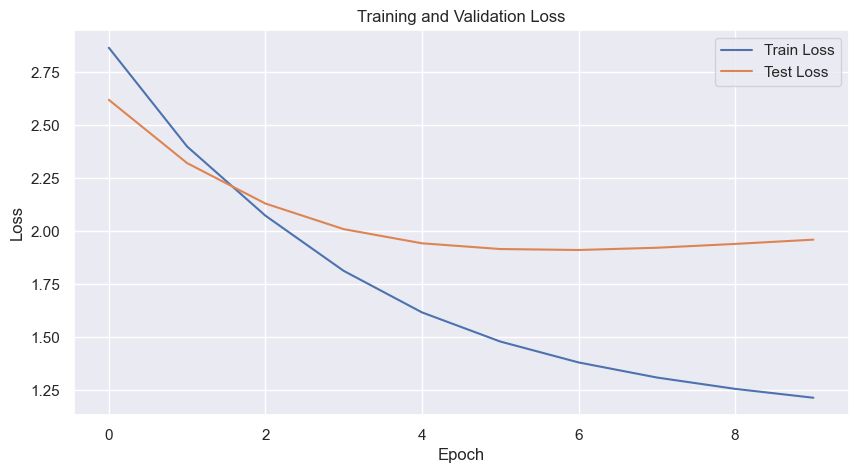

In [21]:
# Plot results
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

## Making predictions

In [22]:
sample_user_ids = [
    "05b9035fe02ebdf5535ae9ec07de1e935ffa43df",
    "4b9b549e84fb29bfbcf7ab34f01c0bcd1bbf93a5",
    "6530c4fc41b9110de5d39fe0355fa103c66385f0",
]
sample_user_ids

['05b9035fe02ebdf5535ae9ec07de1e935ffa43df',
 '4b9b549e84fb29bfbcf7ab34f01c0bcd1bbf93a5',
 '6530c4fc41b9110de5d39fe0355fa103c66385f0']

In [23]:
# sample song ids
sample_song_ids = df[df["user_id"].isin(sample_user_ids)]["song_id"].unique()[:5]
sample_song_ids

array(['SOMWTWK12AB01860CD', 'SOBKRVG12A8C133269', 'SOXFXDH12A8C13326E',
       'SOAYETG12A67ADA751', 'SOUFNSM12A58A77715'], dtype=object)

In [24]:
def predict(model, user_ids, device):
    """
    Make predictions for specific user-song pairs

    Args:
        model: trained MatrixFactorization model
        user_ids: array-like of user_ids (original string IDs)
        device: torch device
    """
    # Convert IDs to indices
    user_indices = torch.tensor(
        [user_to_idx.get(uid, -1) for uid in user_ids], device=device
    )

    # Get predictions
    with torch.no_grad():
        predictions = model.predict_all_songs(
            user_indices
        )  # Shape: (user_ids, n_songs)
        predictions = torch.sigmoid(predictions)

    return predictions.cpu().numpy()

In [25]:
# making predictions
predict(model, sample_user_ids, device)

array([[0.9860952 , 0.98690146, 0.97035867, ..., 0.5272796 , 0.44552663,
        0.24358411],
       [0.46770197, 0.7280549 , 0.768731  , ..., 0.81601435, 0.690786  ,
        0.39057055],
       [0.8232218 , 0.6828612 , 0.92087764, ..., 0.74796975, 0.6760552 ,
        0.3967087 ]], dtype=float32)

In [26]:
def get_top_k_recommendations(model, user_ids, k=10, device="cpu"):
    """
    Get top-k song recommendations for given users
    """
    # convert to list
    if isinstance(user_ids, str):
        user_ids = [user_ids]

    # Get predictions
    probas = predict(model, user_ids, device)  # This returns numpy array
    probas = torch.from_numpy(probas)  # Convert to tensor for torch operations

    # mask for already listened songs
    for i, user_id in enumerate(user_ids):
        user_songs = df[df["user_id"] == user_id]["song_idx"].values
        probas[i, user_songs] = float("-inf")

    # Get top-k indices and probabilities
    top_k_probas, top_k_indices = torch.topk(probas, k, dim=1)

    # Create reverse mapping for song indices to IDs
    idx_to_song = {idx: sid for sid, idx in song_to_idx.items()}

    # a lookup dictionary for song metadata
    song_metadata = (
        df[["song_id", "artist", "title"]]
        .drop_duplicates("song_id")
        .set_index("song_id")
    )

    # Build recommendations dictionary
    recommendations = {}
    for i, user_id in enumerate(user_ids):
        user_recs = []
        for idx, prob in zip(top_k_indices[i], top_k_probas[i]):
            song_id = idx_to_song[idx.item()]
            artist = song_metadata.loc[song_id, "artist"]
            title = song_metadata.loc[song_id, "title"]
            song_info = f"{artist} - {title}"
            rounded_prob = round(float(prob), 2)
            user_recs.append((song_info, rounded_prob))
        recommendations[user_id] = user_recs

    return recommendations

In [27]:
recommendations = get_top_k_recommendations(model, sample_user_ids, k=3, device=device)
recommendations

{'05b9035fe02ebdf5535ae9ec07de1e935ffa43df': [('Metric - Gold Guns Girls',
   0.98),
  ('Vampire Weekend - Horchata', 0.98),
  ('Vampire Weekend - M79 (Album)', 0.98)],
 '4b9b549e84fb29bfbcf7ab34f01c0bcd1bbf93a5': [('Rise Against - Savior', 0.99),
  ('Weezer - Buddy Holly', 0.98),
  ('Pavement - Mercy:The Laundromat', 0.96)],
 '6530c4fc41b9110de5d39fe0355fa103c66385f0': [('Jack Johnson - Bubble Toes',
   1.0),
  ('Jack Johnson - Do You Remember', 0.99),
  ("Kid Cudi Vs Crookers - Day 'N' Nite", 0.99)]}

Here we can evaluate some recommendation for a hardcore fan of an artist

In [28]:
# get specific artist data
artist_df = df[(df.artist == "Eminem") & (df.interaction == 1)]

# Get users who listen to that artist and their total song count
user_total_songs = df[df.interaction == 1].groupby("user_id").size()
user_artist_songs = artist_df.groupby("user_id").size()

# Calculate ratio of artist songs to total songs per user
artist_ratio = pd.DataFrame(
    {"total_songs": user_total_songs, "artist_songs": user_artist_songs}
).fillna(0)
artist_ratio["ratio"] = artist_ratio["artist_songs"] / artist_ratio["total_songs"]
artist_ratio

,total_songs,artist_songs,ratio
user_id,,,
0003798d61a8010dbfd8010180b7107cbbb8a649,19,1.0,0.052632
00061a993bb3add5cc37b2ea28a9552337f2fe4d,16,0.0,0.000000
000a43eb37163bb2f93020e107a2d543f27257b7,11,0.0,0.000000
000ae9c80733348ff64cd3716a27477b94578d9d,10,0.0,0.000000
000dd7137b511a0c6e45880de551c6a7019ee4c3,10,0.0,0.000000
...,...,...,...
fff3b1ee05d9750e8868de9470ea46fcb0776f66,10,0.0,0.000000
fff4438f5d96c5ecd66678f2a22fd7bbed59625f,11,0.0,0.000000
fff5304527f3c658ce48cd7afa5b76b7b4172852,16,1.0,0.062500


In [29]:
# Find users with high artist ratio and a minimum number of artist songs
dedicated_fans = artist_ratio[
    (artist_ratio["ratio"] > 0.3) & (artist_ratio["artist_songs"] > 3)
].sort_values("ratio", ascending=False)
print("Top Eminem fans (by ratio of Eminem songs to total songs):")
print(dedicated_fans.head())

# extract top user id
user_id = dedicated_fans.index[0]


Top Eminem fans (by ratio of Eminem songs to total songs):
                                          total_songs  artist_songs     ratio
user_id                                                                      
1abe450971e4ea9fea6d1c48c36732bbfb2895dc           10           7.0  0.700000
73ad7d3f143b0d7ff5f7e0e1f0f07913e9943755           11           6.0  0.545455
4718c9a2a51067ab538fb460beefa0459002651c           10           5.0  0.500000
7ae393fd4e7e048fedfe228ca209ae44da21a3c6           10           5.0  0.500000
6c6083f4a8b1e0f6ef264203f5583c36628b3b94           10           5.0  0.500000


In [30]:
# get recommendations
recommendations = get_top_k_recommendations(model, [user_id], k=5, device=device)
recommendations


{'1abe450971e4ea9fea6d1c48c36732bbfb2895dc': [('My Chemical Romance - Helena (So Long & Goodnight) (Album Version)',
   0.99),
  ('Eminem - Evil Deeds', 0.99),
  ('Eminem / Dr. Dre - Say What You Say', 0.99),
  ('Blink-182 - Always', 0.98),
  ('Eminem - Without Me', 0.98)]}